<a href="https://colab.research.google.com/github/haraldriisager/ML-Project/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Rows before preprocessing: 10047
Initial rows: 10047
Rows after dropping missing DEP_DELAY: 9748
Rows after classifying delays: 9748
Rows after processing time column CRS_DEP_TIME: 9748


<ipython-input-12-63a0aa2576e3>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delay_category'] = df['DEP_DELAY'].apply(classify_delay)
<ipython-input-12-63a0aa2576e3>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(time_to_minutes)


Rows after processing time column CRS_ARR_TIME: 9748
Weather columns identified: ['origin_temperature_2m', 'origin_precipitation', 'origin_rain', 'origin_snowfall', 'origin_windspeed_10m', 'origin_windspeed_100m', 'origin_winddirection_10m', 'origin_winddirection_100m', 'origin_windgusts_10m', 'destination_temperature_2m', 'destination_precipitation', 'destination_rain', 'destination_snowfall', 'destination_windspeed_10m', 'destination_windspeed_100m', 'destination_winddirection_10m', 'destination_winddirection_100m', 'destination_windgusts_10m']


<ipython-input-12-63a0aa2576e3>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[weather_cols] = df[weather_cols].apply(pd.to_numeric, errors='coerce')
<ipython-input-12-63a0aa2576e3>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[weather_cols] = df[weather_cols].fillna(df[weather_cols].mean())


Rows after converting weather columns to numeric: 9748
Rows after filling missing weather values: 9748
Rows after encoding categorical variables: 9748
Columns with remaining NaN values: ['origin_temperature_2m', 'origin_precipitation', 'origin_rain', 'origin_snowfall', 'origin_windspeed_10m', 'origin_windspeed_100m', 'origin_winddirection_10m', 'origin_winddirection_100m', 'origin_windgusts_10m', 'destination_temperature_2m', 'destination_precipitation', 'destination_rain', 'destination_snowfall', 'destination_windspeed_10m', 'destination_windspeed_100m', 'destination_winddirection_10m', 'destination_winddirection_100m', 'destination_windgusts_10m']
Rows after filling remaining NaN values with 0: 9748
Rows after preprocessing: 9748
Accuracy: 0.9594871794871795
F1 Score: 0.9541991766598338
Classification Report:
                 precision    recall  f1-score   support

Moderate delay       1.00      0.84      0.91       108
      No delay       0.96      1.00      0.98      1613
  Sever

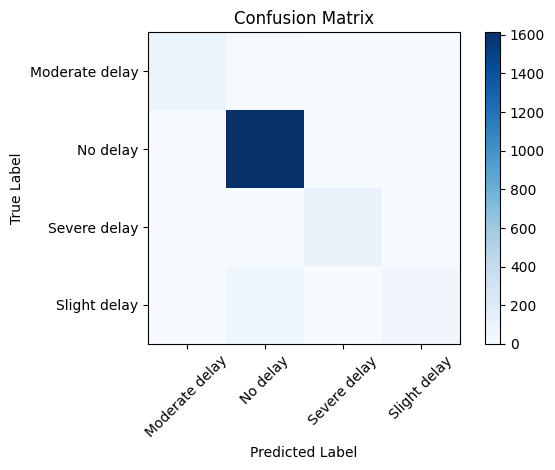

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt

def preprocess_data(df):
    print("Initial rows:", len(df))

    df = df.dropna(subset=['DEP_DELAY'])
    print("Rows after dropping missing DEP_DELAY:", len(df))

    def classify_delay(delay_minutes):
        if delay_minutes <= 15:
            return 'No delay'
        elif 15 < delay_minutes <= 30:
            return 'Slight delay'
        elif 30 < delay_minutes <= 60:
            return 'Moderate delay'
        elif 60 < delay_minutes:
            return 'Severe delay'

    df['delay_category'] = df['DEP_DELAY'].apply(classify_delay)
    print("Rows after classifying delays:", len(df))

    def time_to_minutes(time_str):
        try:
            hours, minutes = map(int, time_str.split(':'))
            return hours * 60 + minutes
        except ValueError:
            return np.nan

    time_cols = ['CRS_DEP_TIME', 'CRS_ARR_TIME']
    for col in time_cols:
        if col in df.columns:
            df[col] = df[col].apply(time_to_minutes)
            print(f"Rows after processing time column {col}:", len(df))

    weather_cols = [col for col in df.columns if col.startswith('origin_') or col.startswith('destination_')]
    print("Weather columns identified:", weather_cols)
    df[weather_cols] = df[weather_cols].apply(pd.to_numeric, errors='coerce')
    print("Rows after converting weather columns to numeric:", len(df))

    df[weather_cols] = df[weather_cols].fillna(df[weather_cols].mean())
    print("Rows after filling missing weather values:", len(df))

    df = pd.get_dummies(df, columns=['AIRLINE', 'ORIGIN', 'DEST'], drop_first=True)
    print("Rows after encoding categorical variables:", len(df))

    target_leaking_cols = ['ARR_DELAY', 'DELAY_DUE_WEATHER']
    df = df.drop(columns=target_leaking_cols, errors='ignore')

    remaining_na_columns = df.columns[df.isna().any()].tolist()
    print("Columns with remaining NaN values:", remaining_na_columns)

    df[remaining_na_columns] = df[remaining_na_columns].fillna(0)
    print("Rows after filling remaining NaN values with 0:", len(df))

    return df

df = pd.read_csv('flight_data_with_weather.csv')
print("Rows before preprocessing:", len(df))
df = preprocess_data(df)
print("Rows after preprocessing:", len(df))

if df.empty:
    raise ValueError("Preprocessing removed all rows. Check the preprocessing steps.")

label_encoder = LabelEncoder()
scaler = StandardScaler()
df['delay_category'] = label_encoder.fit_transform(df['delay_category'])
X = df.drop(['delay_category', 'FL_DATE'], axis=1)
y = df['delay_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_cols = ['CRS_DEP_TIME', 'CRS_ARR_TIME'] + [
    col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64']
]
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

model = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_pred_labels = label_encoder.inverse_transform(y_pred)
y_test_labels = label_encoder.inverse_transform(y_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels, labels=label_encoder.classes_)
report = classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)

plt.figure()
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(np.arange(len(label_encoder.classes_)), label_encoder.classes_, rotation=45)
plt.yticks(np.arange(len(label_encoder.classes_)), label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [31]:
!pip install gdown
import gdown
import pandas as pd

file_id = '1Uf3q-CoSVK84kogmfTAtvIZ3k8crjN1d'
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'data.csv', quiet=False)
df = pd.read_csv('data.csv')

print(df.head())

Downloading...
From (original): https://drive.google.com/uc?id=1Uf3q-CoSVK84kogmfTAtvIZ3k8crjN1d
From (redirected): https://drive.google.com/uc?id=1Uf3q-CoSVK84kogmfTAtvIZ3k8crjN1d&confirm=t&uuid=b517aa0b-dc34-4644-96a4-27c88768ca06
To: /content/data.csv
100%|██████████| 256M/256M [00:01<00:00, 141MB/s]


   FlightID    Airline  FlightNumber Origin Destination ScheduledDeparture  \
0         1     United          4558    ORD         MIA   2024-09-01 08:11   
1         2      Delta          8021    LAX         MIA   2024-09-01 10:25   
2         3  Southwest          7520    DFW         SFO   2024-09-01 16:53   
3         4      Delta          2046    ORD         BOS   2024-09-01 14:44   
4         5      Delta          6049    LAX         SEA   2024-09-01 01:51   

    ActualDeparture  ScheduledArrival     ActualArrival  DelayMinutes  \
0  2024-09-01 08:30  2024-09-01 12:11  2024-09-01 12:19             8   
1  2024-09-01 10:41  2024-09-01 13:25  2024-09-01 13:27             2   
2  2024-09-01 17:05  2024-09-01 17:53  2024-09-01 18:07            14   
3  2024-09-01 15:04  2024-09-01 18:44  2024-09-01 18:34           -10   
4  2024-09-01 02:08  2024-09-01 05:51  2024-09-01 06:15            24   

           DelayReason  Cancelled  Diverted AircraftType TailNumber  Distance  
0           

Airline            int64
FlightNumber     float64
Origin             int64
Destination        int64
Distance         float64
DelayReason        int64
AircraftType       int64
DepartureHour    float64
ArrivalHour      float64
dtype: object
              precision    recall  f1-score   support

    No delay       0.67      0.83      0.74    222103
Slight delay       0.50      0.30      0.37    127423

    accuracy                           0.64    349526
   macro avg       0.59      0.56      0.56    349526
weighted avg       0.61      0.64      0.61    349526

Confusion Matrix:
[[184369  37734]
 [ 89722  37701]]


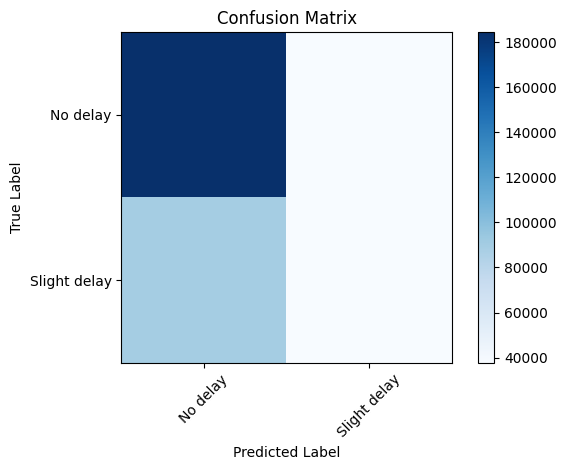

Training set class distribution:
delay_category
No delay        886207
Slight delay    511894
Name: count, dtype: int64


In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt

def classify_delay(delay_minutes):
    if delay_minutes <= 15:
        return 'No delay'
    elif 15 < delay_minutes <= 30:
        return 'Slight delay'
    elif 30 < delay_minutes <= 60:
        return 'Moderate delay'
    elif 60 < delay_minutes:
        return 'Severe delay'

df['delay_category'] = df['DelayMinutes'].apply(classify_delay)

from sklearn.preprocessing import LabelEncoder, StandardScaler

features = ['Airline', 'FlightNumber', 'Origin', 'Destination', 'ScheduledDeparture',
            'ScheduledArrival', 'Distance', 'DelayReason', 'AircraftType']

df = df[features + ['delay_category']].copy()


label_encoder = LabelEncoder()
for col in ['Airline', 'Origin', 'Destination', 'DelayReason', 'AircraftType']:
    df[col] = df[col].fillna("Unknown").infer_objects().astype(str)
    df[col] = label_encoder.fit_transform(df[col])

df['ScheduledDeparture'] = pd.to_datetime(df['ScheduledDeparture'], errors='coerce')
df['ScheduledArrival'] = pd.to_datetime(df['ScheduledArrival'], errors='coerce')

df = df.dropna(subset=['ScheduledDeparture', 'ScheduledArrival'])

df['DepartureHour'] = df['ScheduledDeparture'].dt.hour
df['ArrivalHour'] = df['ScheduledArrival'].dt.hour

scaler = StandardScaler()
df[['FlightNumber', 'Distance', 'DepartureHour', 'ArrivalHour']] = scaler.fit_transform(
    df[['FlightNumber', 'Distance', 'DepartureHour', 'ArrivalHour']]
)

from sklearn.model_selection import train_test_split

X = df.drop('delay_category', axis=1)
y = df['delay_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestClassifier

X_train = X_train.drop(columns=['ScheduledDeparture', 'ScheduledArrival'], errors='ignore')

print(X_train.dtypes)

rf_model = RandomForestClassifier(class_weight={'No delay': 1, 'Slight delay': 1, 'Moderate delay': 5, 'Severe delay': 5}, n_estimators=50, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

from sklearn.metrics import classification_report, confusion_matrix

X_train = X_train.drop(['ScheduledArrival', 'ScheduledDeparture'], axis=1, errors='ignore')
X_test = X_test.drop(['ScheduledArrival', 'ScheduledDeparture'], axis=1, errors='ignore')

y_pred = rf_model.predict(X_test)

print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
print("Confusion Matrix:")
print(conf_matrix)
plt.figure()
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
classes = np.unique(y_test)
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

print("Training set class distribution:")
print(y_train.value_counts())